In [ ]:
import os
import numpy as np
import pandas as pd
from vertexai.language_models import TextEmbeddingModel,TextEmbedding
from sklearn.cluster import KMeans
import psycopg2
# from psycopg2.extras import register_vector
from pgvector.psycopg2 import register_vector

import json # For JSONB column

In [15]:
# Load environment variables from .env file

from dotenv import load_dotenv # Import load_dotenv

load_dotenv(override=True)

# --- Configuration (loaded from environment variables) ---
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
REGION = os.getenv("GCP_REGION")

DB_HOST = os.getenv("DB_HOST") 
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT", "5432") 

EMBEDDING_MODEL_NAME = os.getenv("EMBEDDING_MODEL_NAME")
EMBEDDING_DIMENSION = int(os.getenv("EMBEDDING_DIMENSION")) 
K_CLUSTERS = int(os.getenv("K_CLUSTERS")) 

INCIDENTS_CSV_PATH = os.getenv("INCIDENTS_CSV_PATH")
# The GOOGLE_APPLICATION_CREDENTIALS path is automatically set by load_dotenv()
# if it's present in the .env file. The client library will pick it up.


In [16]:
# --- Validation (Optional but Recommended) ---
# Check if critical environment variables are loaded
# Note: GOOGLE_APPLICATION_CREDENTIALS is set as an env var by load_dotenv, so it can be checked here.
if not all([PROJECT_ID, REGION, DB_HOST, DB_NAME, DB_USER, DB_PASSWORD, os.getenv("GOOGLE_APPLICATION_CREDENTIALS")]):
    print("Error: One or more critical environment variables are not set.")
    print("Please check your .env file and ensure all required variables are present.")
    exit(1)

print(f"PROJECT_ID : {PROJECT_ID}")
print(f"REGION : {REGION}")
print(f"DB_HOST : {DB_HOST}")
print(f"DB_NAME : {DB_NAME}")
print(f"DB_USER : {DB_USER}")
print(f"DB_PASSWORD : {DB_PASSWORD}")
print(f"INCIDENTS_CSV_PATH : {INCIDENTS_CSV_PATH}")

PROJECT_ID : poetic-analog-460707-i9
REGION : us-central1
DB_HOST : 34.66.49.57
DB_NAME : incidents_db
DB_USER : postgres
DB_PASSWORD : postgres
INCIDENTS_CSV_PATH : G:/POC's/Process Mining/Process_Mining/datasets/mock_incidents_10.csv


In [17]:
# Establish a connection *before* registering the vector type
# This connection will be used *only* for type registration.
# The main data loading function will establish its own connection.
conn_for_type_reg = None
try:
    conn_for_type_reg = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    # Register vector type for psycopg2 using the newly opened connection
    register_vector(conn_for_type_reg) 
    print("pgvector type registered successfully with psycopg2.")
except psycopg2.Error as e:
    print(f"Database connection error during type registration: {e}")
    print("Please check your database connection details in the .env file.")
    exit(1)
except Exception as e:
    print(f"Error registering pgvector type: {e}")
    print("Please ensure the 'pgvector' Python library is installed (pip install pgvector).")
    exit(1)
finally:
    if conn_for_type_reg:
        conn_for_type_reg.close() # Close the connection used for type registration


pgvector type registered successfully with psycopg2.


In [ ]:
# --- Initialize Vertex AI Embedding Model ---

try:
    embedding_model = TextEmbeddingModel.from_pretrained(EMBEDDING_MODEL_NAME)
    print(f"Initialized Vertex AI Embedding Model: {EMBEDDING_MODEL_NAME}")
except Exception as e:
    print(f"Error initializing embedding model: {e}")
    print("Please ensure your Google Cloud credentials are set up correctly (e.g., GOOGLE_APPLICATION_CREDENTIALS in .env).")
    exit()

Initialized Vertex AI Embedding Model: text-embedding-004


In [19]:
def get_gecko_embedding(texts: str | list[str]) -> list[float] | list[list[float]]:
    """
    Generates embeddings for the given text(s) using Vertex AI Gecko model.
    Handles both single string and a list of strings for batch processing.

    Args:
        texts: A single string or a list of strings to embed.

    Returns:
        A list of floats if a single string was provided.
        A list of lists of floats if a list of strings was provided.
        Returns a zero vector or list of zero vectors on error.
    """
    is_single_text = isinstance(texts, str)
    texts_to_embed = [texts] if is_single_text else texts

    if not texts_to_embed: # Handle empty list case
        return [] if not is_single_text else [0.0] * EMBEDDING_DIMENSION

    # Vertex AI's text-embedding-004 has a batch size limit (e.g., 250 requests per call).
    # The client library often handles chunking internally, but for very large datasets,
    # you might manually chunk it if you encounter issues.
    
    # Define a default zero vector for errors (matching embedding dimension)
    zero_vector = [0.0] * EMBEDDING_DIMENSION

    try:
        batch_embeddings_response: list[TextEmbedding] = embedding_model.get_embeddings(texts_to_embed)
        
        results = [emb.values for emb in batch_embeddings_response]
        
        if is_single_text:
            return results[0] # Return single list if single text was input
        else:
            return results # Return list of lists if list of texts was input
            
    except Exception as e:
        print(f"Error generating embeddings for text(s): '{texts_to_embed[0][:50]}...'. Error: {e}")
        # Return appropriate error structure based on input type
        if is_single_text:
            return zero_vector
        else:
            return [zero_vector] * len(texts_to_embed) # Return list of zero vectors



In [20]:
def load_data_to_pgvector(df: pd.DataFrame, embeddings: list[list[float]], cluster_assignments: list[int]):
    """Loads incident data, embeddings, and cluster assignments into pgvector."""
    conn = None
    cur = None 

    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            port=DB_PORT
        )
        cur = conn.cursor()

        # Clear existing data for demonstration (optional)
        cur.execute("DELETE FROM incidents;")
        print("Cleared existing data from 'incidents' table.")

        # Prepare and execute the insert statement
        insert_query = """
        INSERT INTO incidents (id, description, embedding, cluster_id, created_at, updated_at, status, priority, metadata)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """

        for i, row in df.iterrows():
            incident_id = row['id']
            description = row['description']
            embedding = embeddings[i]
            # cluster_id = cluster_assignments[i]
            # --- Convert the numpy.int32 from cluster_assignments[i] to a Python int ---
            # cluster_assignments is generated directly from kmeans.labels_ which is a numpy array.
            cluster_id = int(cluster_assignments[i])
            created_at = row['created_at']
            updated_at = row['updated_at']
            status = row['status']
            priority = row['priority']
            
            # Prepare metadata for JSONB column (example: exclude already mapped fields)
            other_metadata = {
                k: v for k, v in row.items() 
                if k not in ['id', 'description', 'created_at', 'updated_at', 'status', 'priority']
            }
            # metadata_json = json.dumps(other_metadata)
            metadata_json = json.dumps(other_metadata, default=lambda x: int(x) if isinstance(x, np.integer) else x)


            cur.execute(insert_query, (
                incident_id, description, embedding, cluster_id,
                created_at, updated_at, status, priority, metadata_json
            ))
        
        conn.commit()
        print(f"Successfully loaded {len(df)} incidents into 'incidents' table.")

    except psycopg2.Error as e:
        print(f"Database error: {e}")
        if conn:
            conn.rollback()
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if cur:
            cur.close()
        if conn:
            conn.close()

In [21]:
print("Starting data processing with psycopg2...")

# 1. Fetch Mock Incidents

INCIDENTS_CSV_PATH = os.getenv("INCIDENTS_CSV_PATH")
print(f"Loading incidents from CSV: {INCIDENTS_CSV_PATH}...")

try:
    # pd.read_csv automatically infers types, but we explicitly parse dates
    incidents_df = pd.read_csv(
        INCIDENTS_CSV_PATH,
        parse_dates=['created_at', 'updated_at'], # Parse these columns as datetime objects
        dayfirst=True # Adjust based on your date format (e.g., True for DD/MM/YYYY)
    )
    print(f"Loaded {len(incidents_df)} incidents from CSV.")
    print("First 5 rows of loaded data:")
    print(incidents_df.head())
except FileNotFoundError:
    print(f"Error: CSV file not found at {INCIDENTS_CSV_PATH}. Please check your .env file path.")
    exit(1)
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit(1)

Starting data processing with psycopg2...
Loading incidents from CSV: G:/POC's/Process Mining/Process_Mining/datasets/mock_incidents_10.csv...
Loaded 10 incidents from CSV.
First 5 rows of loaded data:
         id                                        description  \
0  INC-1000  Urgent: Server CPU spike impacts Email Service...   
1  INC-1001  Urgent: API endpoint timeout impacts Internal ...   
2  INC-1002  Resolved: Database performance degradation aft...   
3  INC-1003  Urgent: Storage capacity alert impacts ERP ava...   
4  INC-1004  Alert triggered: Network connectivity issue de...   

                   created_at                  updated_at    status priority  
0  2025-01-04 16:33:22.006729  2025-01-05 22:33:22.006729      Open     High  
1  2025-05-05 01:33:22.006729  2025-05-05 08:33:22.006729  Resolved      Low  
2  2025-01-30 00:33:22.006729  2025-01-30 09:33:22.006729  Resolved      Low  
3  2024-10-14 22:33:22.006729  2024-10-16 07:33:22.006729  Resolved      Low  
4  202

In [22]:
# 2. Generate Embeddings for all incidents in a single batch using the updated function

print("Generating embeddings for incidents in batch...")
descriptions_to_embed = incidents_df['description'].tolist()

try:
    all_embeddings = get_gecko_embedding(descriptions_to_embed) # Call the updated function
    print(f"Successfully generated {len(all_embeddings)} embeddings in batch.")
except Exception as e:
    print(f"Error during batch embedding generation: {e}")
    print("Please review your Vertex AI quota or the descriptions data.")
    exit(1)


Generating embeddings for incidents in batch...
Successfully generated 10 embeddings in batch.


In [23]:
# 3. Perform K-means Clustering

print(f"Performing K-means clustering with K={K_CLUSTERS}...")
try:
    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
    kmeans.fit(all_embeddings)
    cluster_assignments = kmeans.labels_
    print("K-means clustering complete.")
except Exception as e:
    print(f"Error during K-means clustering: {e}")
    cluster_assignments = [0] * len(all_embeddings)

incidents_df['cluster_id'] = cluster_assignments

Performing K-means clustering with K=5...
K-means clustering complete.


##### Dimensionality Reduction for Visualization (Highly Recommended)


--- Visualizing Clusters (requires matplotlib and optionally seaborn) ---
Applying PCA for 2D visualization...


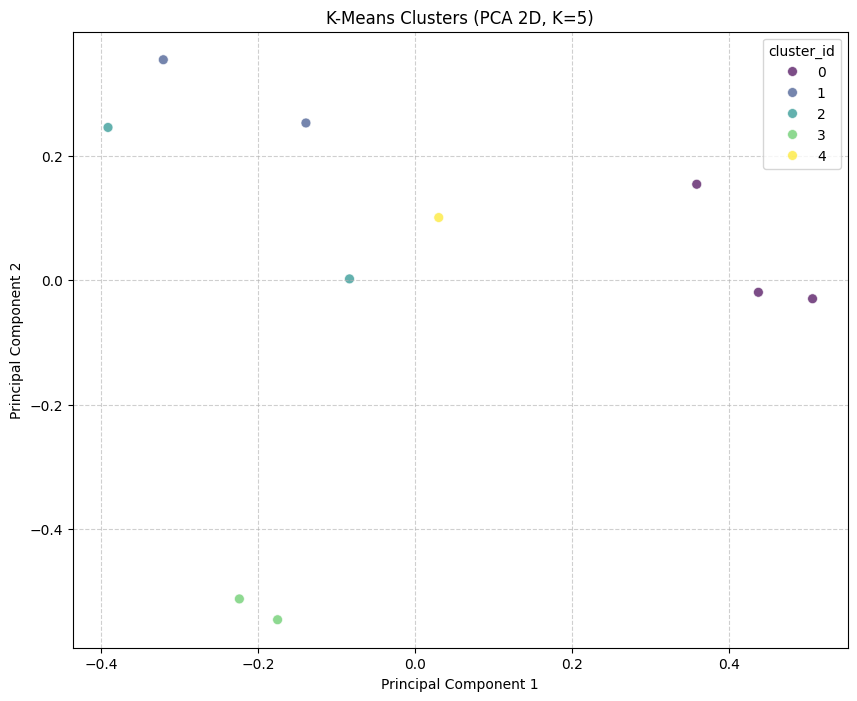

PCA plot displayed.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns # Optional, for nicer plots
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# ... (after incidents_df['cluster_id'] = cluster_assignments)

print("\n--- Visualizing Clusters (requires matplotlib and optionally seaborn) ---")

# Convert all_embeddings to a NumPy array for scikit-learn
all_embeddings_np = np.array(all_embeddings)

# --- Option 1: PCA for 2D visualization ---
print("Applying PCA for 2D visualization...")
try:
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d_pca = pca.fit_transform(all_embeddings_np)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embeddings_2d_pca[:, 0],
        y=embeddings_2d_pca[:, 1],
        hue=incidents_df['cluster_id'],
        palette='viridis', # Or 'deep', 'Paired', etc.
        legend='full',
        s=50, # Marker size
        alpha=0.7 # Transparency
    )
    plt.title(f'K-Means Clusters (PCA 2D, K={K_CLUSTERS})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("PCA plot displayed.")

except Exception as e:
    print(f"Error during PCA visualization: {e}")

In [25]:
# 4. Load Data into pgvector
print("Loading data into pgvector...")
load_data_to_pgvector(incidents_df, all_embeddings, cluster_assignments)
print("Data loading process finished.")

Loading data into pgvector...
Cleared existing data from 'incidents' table.
Successfully loaded 10 incidents into 'incidents' table.
Data loading process finished.
